In [36]:
import numpy as np
import itertools as it

from helpers import *

from tqdm import tqdm
from implementations import *
from cross_validation import build_k_fold_sets
from feature_eng import *
from data_cleaning import replace_invalid
from plots import display_features

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
y_train, x_brute_train, indices_train = load_csv_data("../data/train.csv")

In [38]:
y_test, x_brute_test, indices_test = load_csv_data("../data/test.csv")

In [39]:
y_train.shape, x_brute_train.shape, y_test.shape, x_brute_test.shape

((250000,), (250000, 30), (568238,), (568238, 30))

In [166]:
train_size = x_brute_train.shape[0]
test_size = x_brute_test.shape[0]

train_size, test_size

(250000, 568238)

In [41]:
x_brute = np.vstack((x_brute_train, x_brute_test))
x_brute.shape

(818238, 30)

# Data Cleaning

In [42]:
mask_invalid = x_brute == -999.0

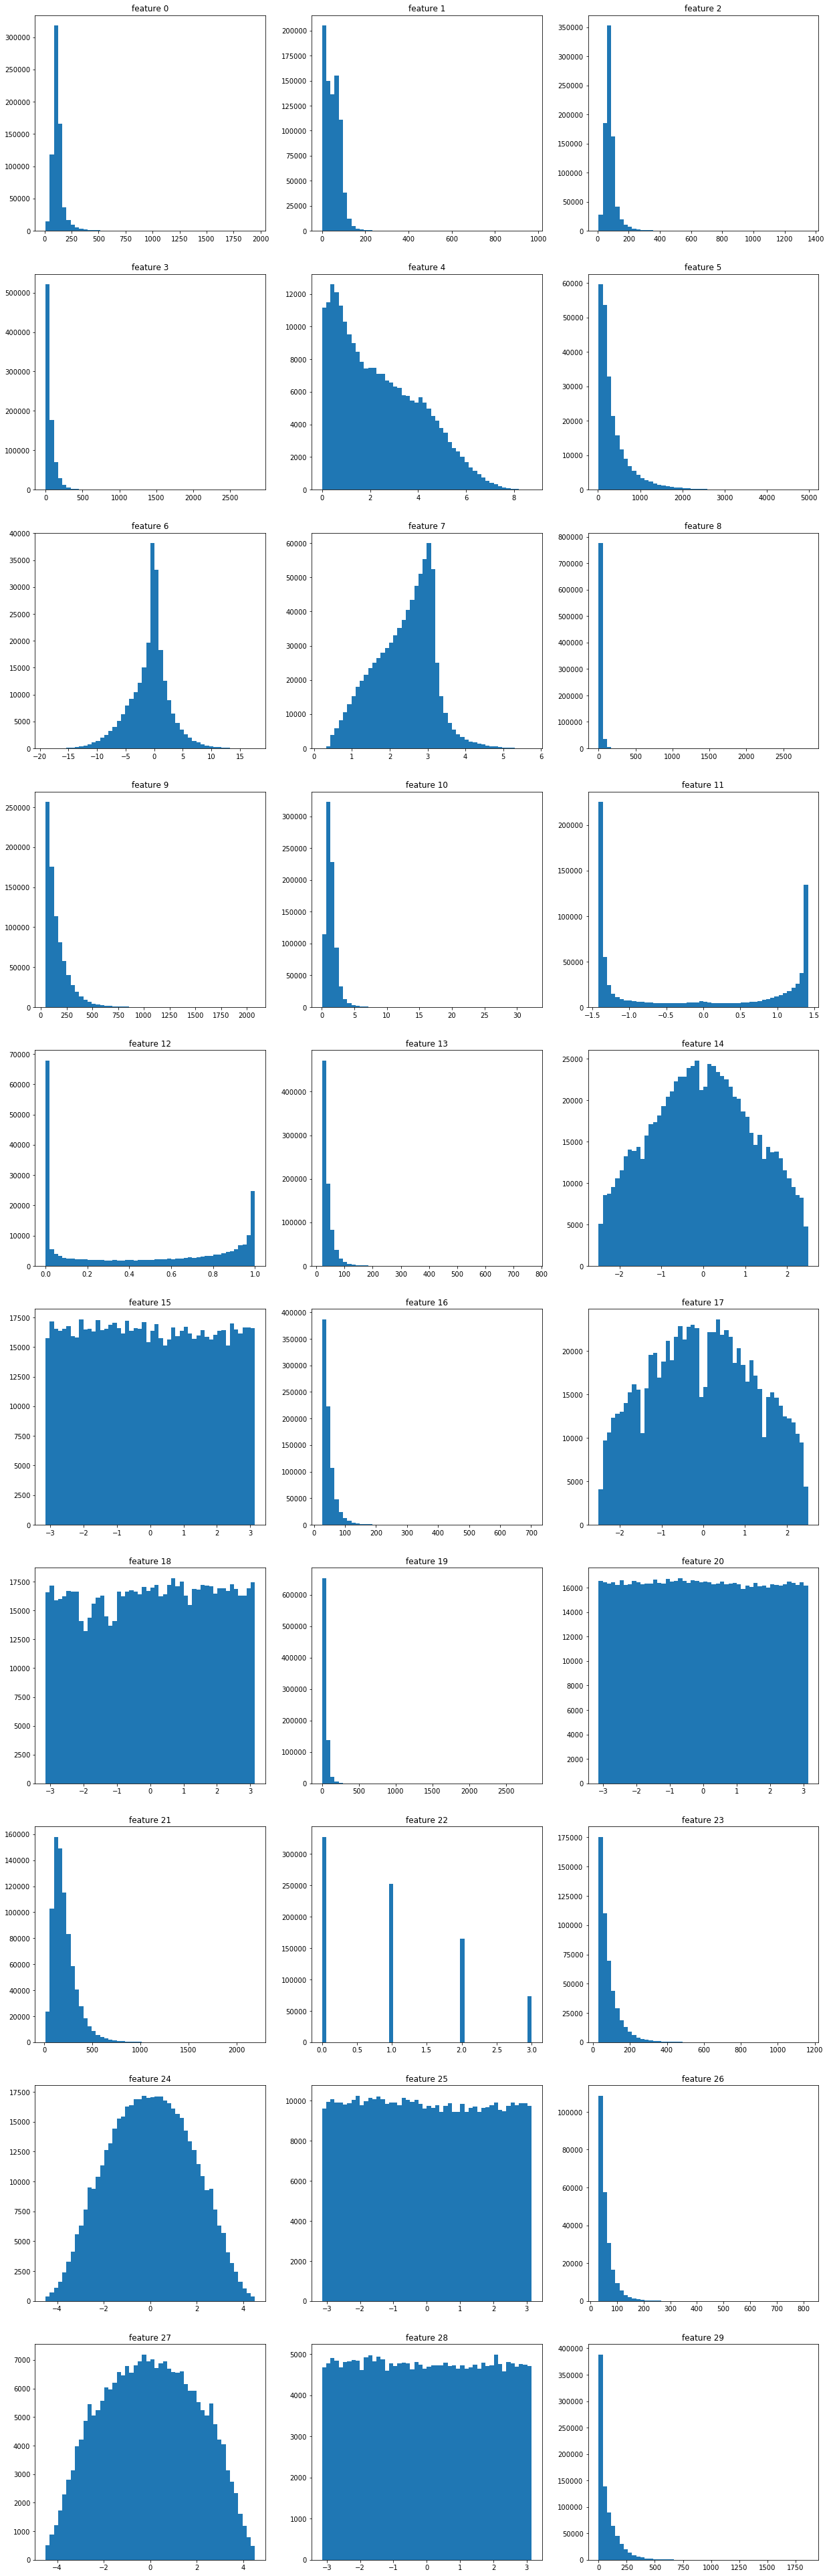

In [43]:
display_features(x_brute, ~mask_invalid, bins=50)

In [44]:
x_min_values = np.ma.array(x_brute, mask=mask_invalid).min(axis=0)
x_min_values.shape

(30,)

C:\Users\cleme\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


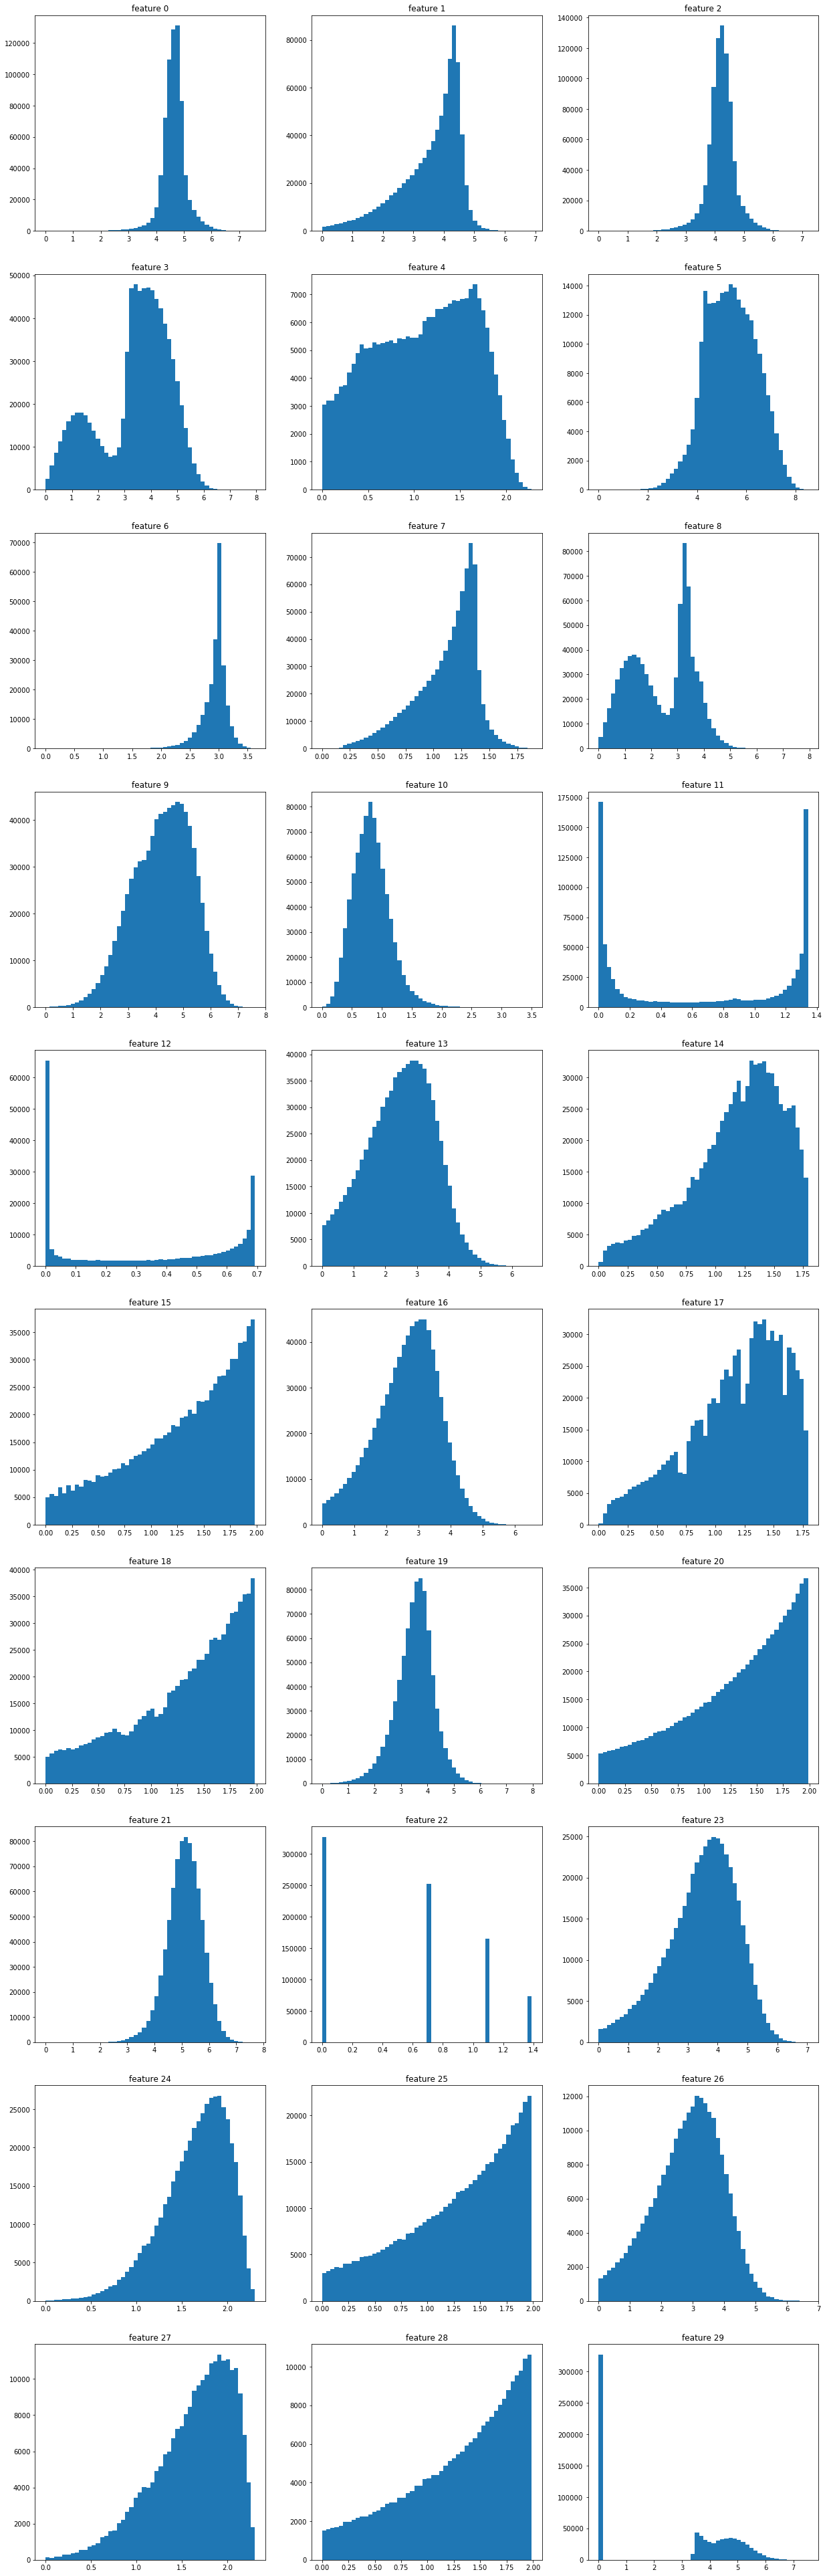

In [124]:
display_features(np.log(x_brute - x_min_values + 1), ~mask_invalid, bins=50)

### Invalid values replaced by the mean

In [295]:
x_replaced_invalid = replace_invalid(x_brute, mask_invalid, replace_by="mean")
x_replaced_invalid.shape

(818238, 30)

In [296]:
def verify_masks(masks):
    total = 0
    for mask in masks:
        total += mask.sum()
    assert total == x_brute.shape[0]
    return len(masks)

## Conditioning on feature #3

In [297]:
limit = 3
masks_feat_3 = [
    np.log(x_brute - x_min_values + 1)[:, 3] < limit,
    np.log(x_brute - x_min_values + 1)[:, 3] > limit
]

verify_masks(masks_feat_3)

C:\Users\cleme\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cleme\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


2

## Conditioning on feature #8

In [298]:
limit = 2.7
masks_feat_8 = [
    np.log(x_brute - x_min_values + 1)[:, 8] < limit,
    np.log(x_brute - x_min_values + 1)[:, 8] > limit
]

verify_masks(masks_feat_8)

C:\Users\cleme\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cleme\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


2

## Conditioning on feature #22
feature 22 has 4 different values (0, 1, 2, 3)

In [299]:
feature_22_values = np.unique(x_brute[:, 22]).tolist()
feature_22_values

[0.0, 1.0, 2.0, 3.0]

In [300]:
def mask_feat_22(value):
    assert value in feature_22_values
    return x_replaced_invalid[:, 22] == value

In [301]:
masks_feat_22 = [
    mask_feat_22(0),
    mask_feat_22(1),
    mask_feat_22(2) | mask_feat_22(3)
]

verify_masks(masks_feat_22)

3

## Conditioning on feature #29
feature 29 is 0 (40%) or 30+

In [302]:
masks_feat_29 = [
    x_replaced_invalid[:, 22] == 0,
    x_replaced_invalid[:, 22] != 0
]


verify_masks(masks_feat_29)

2

## Standardization of the data

In [114]:
x_cleaned = standardize(x_replaced_invalid)
x_cleaned.shape

(818238, 30)

Test #01 remove features with invalid data

In [48]:
#x_cleaned = x_cleaned[:, mask_invalid.sum(axis=0) == 0]
#x_cleaned.shape

Test #02 handle differently 5 phi features (15, 18, 20, 25, 28)

In [77]:
phi_features = set([15, 18, 20, 25, 28])
x_cleaned_angles = x_cleaned[:, [f for f in range(x_cleaned.shape[1]) if f in phi_features]]
x_cleaned_no_angles = x_cleaned[:, [f for f in range(x_cleaned.shape[1]) if f not in phi_features]]
x_cleaned_angles.shape, x_cleaned_no_angles.shape

((818238, 5), (818238, 25))

# Features Engineering

## Polynomial features

In [63]:
degree = 10

poly_features = build_poly(x_cleaned_no_angles, degree)
poly_features.shape

(818238, 275)

## Functions features

### Features with functions (cos, tan) for angles

In [51]:
cos_features = np.cos(x_cleaned_angles)
cos_features.shape

(818238, 5)

In [52]:
tan_features = np.tan(x_cleaned_angles)
tan_features.shape

(818238, 5)

### Features with functions (log, exp)

In [53]:
x_cleaned_positive = x_cleaned_no_angles - (x_cleaned_no_angles.min(axis=0) - 1)
mask_negative_values = ~np.any(x_cleaned_positive <= 0, axis=0)
non_negative_features = x_cleaned_positive[:, mask_negative_values]

log_features = np.log(non_negative_features)
log_features.shape

(818238, 25)

In [54]:
exp_features = np.exp(x_cleaned_no_angles)
exp_features.shape

(818238, 25)

In [55]:
functions_features = np.hstack((cos_features, tan_features, log_features))
functions_features.shape

(818238, 60)

## Indicator features

### feature value is invalid (1) or not (0)

In [56]:
features_with_invalid = indicator_features(mask_invalid)
features_with_invalid.shape

(818238, 11)

## Combinations of features

In [57]:
x_cleaned_no_angles.shape

(818238, 25)

In [60]:
#combinations = np.ones((x_cleaned_angles.shape[0], 1))
combinations = []
for i in range(x_cleaned_no_angles.shape[1]):
    for j in range(x_cleaned_no_angles.shape[1]):
        if i != j:
            comb = (x_cleaned_no_angles[:, i] * x_cleaned_no_angles[:, j]).reshape((x_cleaned_angles.shape[0], 1))
            combinations.append(comb)


combinations_features = np.concatenate(combinations, axis=1)
combinations_features.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.01it/s]


(818238, 600)

## Concat all features

In [65]:
features = np.concatenate((poly_features, functions_features, combinations_features, features_with_invalid), axis=1)
#features = np.concatenate((np.ones((len(x_brute), 1)), poly_features, features_with_invalid), axis=1)
features.shape

(818238, 946)

# Separating Training and Test data

In [66]:
x_train = features[:train_size]
x_test = features[train_size:]

x_train.shape, x_test.shape

((250000, 946), (568238, 946))

# Cross validation

## Ridge

In [116]:
def cross_validation_ridge(y_train, x_train, k_fold, lambda_, seed=np.random.seed()):
    test_losses = []
    for x_tr, x_va, y_tr, y_va in build_k_fold_sets(y_train, x_train, k_fold, seed):
        w = ridge_regression(y_tr, x_tr, lambda_)

        y_tr_pred = predict_labels(w, x_tr)
        train_loss = (y_tr_pred == y_tr).mean()

        y_te_pred = predict_labels(w, x_va)
        test_loss = (y_te_pred == y_va).mean()

        test_losses.append(test_loss)

    return test_losses

In [287]:
def cross_validation_logistic(y_train, x_train, k_fold, initial_w, max_iters, gamma, seed=np.random.seed()):
    test_losses = []
    for x_tr, x_va, y_tr, y_va in build_k_fold_sets(y_train, x_train, k_fold, seed):
        #y_tr = (y_tr + 1) / 2
        #y_va = (y_va + 1) / 2
            
        w, loss = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
        
        y_tr_pred = predict_labels(w, x_tr, )#logistic=True)
        train_loss = (y_tr_pred == y_tr).mean()

        y_te_pred = predict_labels(w, x_va, )#logistic=True)
        test_loss = (y_te_pred == y_va).mean()
        print(test_loss)

        test_losses.append(test_loss)
        
    return test_losses

In [288]:
#ridge
lambda_ = 0.001

#logistic
initial_w = np.zeros((x_train.shape[1]))
max_iters = 200
gamma = 0.1


k_fold = 4
iters = 5

losses = []
for mask in masks_feat_22:
    v_losses = []
    mask = mask[:train_size]
    for _ in range(iters):
        loss = cross_validation_ridge(y_train[mask], x_train[mask], k_fold, lambda_)
        v_losses.extend(loss)
    losses.append(np.array(v_losses).mean() * mask.sum() / train_size)
    np_v_losses = np.array(v_losses)
    
    print("Test Error Mean = {}".format(np_v_losses.mean() * 100))
    print("Test Error St.D = {}".format(np_v_losses.std() * 100))
    
np_losses = np.array(losses)
print("Final Test Error = {}".format(np_losses.sum()))


Test Error Mean = 83.60116902874528
Test Error St.D = 3.415976589596842
Test Error Mean = 80.87331063654183
Test Error St.D = 0.24401777115956436
Test Error Mean = 83.8993658671078
Test Error St.D = 0.2737191705808363
Final Test Error = 0.828415811970665


In [303]:
data_masks = []
for mask_i in masks_feat_8:
    for mask_j in masks_feat_22:
        data_masks.append(mask_i & mask_j)
        print((mask_i & mask_j).sum())
        
verify_masks(data_masks)

192086
133623
92524
135285
119259
145461


6

In [304]:
#ridge
lambda_ = 0.001

k_fold = 4
iters = 5

losses = []
for mask in data_masks:
    v_losses = []
    mask = mask[:train_size]
    for _ in range(iters):
        loss = cross_validation_ridge(y_train[mask], x_train[mask], k_fold, lambda_)
        v_losses.extend(loss)
    losses.append(np.array(v_losses).mean() * mask.sum() / train_size)
    np_v_losses = np.array(v_losses)
    
    print("Test Error Mean = {}".format(np_v_losses.mean() * 100))
    print("Test Error St.D = {}".format(np_v_losses.std() * 100))
    
np_losses = np.array(losses)
print("Final Test Error = {}".format(np_losses.sum()))


Test Error Mean = 86.37470248214892
Test Error St.D = 0.17725991091052162
Test Error Mean = 81.93428515548602
Test Error St.D = 0.26683219517656526
Test Error Mean = 85.79048023799403
Test Error St.D = 0.3536041854967966
Test Error Mean = 81.64670950155761
Test Error St.D = 2.939508685279633
Test Error Mean = 79.80840611353712
Test Error St.D = 0.39270176593734524
Test Error Mean = 82.66431924882627
Test Error St.D = 0.17859382032582896
Final Test Error = 0.8318516164193677


In [305]:
def pred_ridge_with_conditioning(y_train, x_train, lambda_, x_test):
    y_sub = np.zeros(test_size)
    for mask in data_masks:
        w = ridge_regression(y_train[mask[:train_size]], x_train[mask[:train_size]], lambda_)
        y_sub_part = predict_labels(w, x_test[mask[train_size:]])
        y_sub[mask[train_size:]] = y_sub_part
    return y_sub

# Submission

In [306]:
y_submission = pred_ridge_with_conditioning(y_train, x_train, lambda_, x_test)
# w_submission, _ = logistic_regression(y_train, x_train, initial_w, max_iters, gamma)
# y_submission = predict_labels(w, x_test)

In [307]:
create_csv_submission(indices_test, y_submission, "pred07.csv")

# Advanced

In [ ]:
poly_features.shape

In [ ]:
poly_features[:, 0] * poly_features[:, 1]

In [ ]:
def get_feature_with_degree(poly, feature_idx, degree, total_features):
    # poly start with total_features of degree 1, then of degree 2... etc
    return poly[:, feature_idx + (degree - 1) * total_features]

In [ ]:
def product_poly(poly, features_idx, degrees, total_features):
    idx1, idx2 = features_idx
    deg1, deg2 = degrees
    return get_feature_with_degree(poly, idx1, deg1, total_features) * get_feature_with_degree(poly, idx2, deg2, total_features) 

In [ ]:
def build_cross_poly(poly, deg, max_degree=1):
    num_features = poly.shape[1] // deg
    for i_x, j_x in tqdm(list(it.combinations_with_replacement(range(num_features), 2))):
        if i_x != j_x:
            for i_deg, j_deg in it.combinations_with_replacement(range(1, max_degree + 1), 2):
                if i_deg <= max_degree and j_deg <= max_degree:
                    if i_deg == j_deg:
                        new_poly = product_poly(poly, (i_x, j_x), (i_deg, j_deg), num_features)
                        poly = np.c_[poly, new_poly]
                    else:
                        new_poly_1 = product_poly(poly, (i_x, j_x), (i_deg, j_deg), num_features)
                        new_poly_2 = product_poly(poly, (i_x, j_x), (j_deg, i_deg), num_features)
                        poly = np.c_[poly, new_poly_1, new_poly_2]
    return poly

In [ ]:
cross_poly = build_cross_poly(poly_features, 9)

In [ ]:
poly_features.shape